In [ ]:
# default_exp data.external

# External data

> Helper functions used to download and extract common time series datasets.

In [ ]:
#export
from tqdm import tqdm
import zipfile
import tempfile
try: from urllib import urlretrieve
except ImportError: from urllib.request import urlretrieve
import shutil
import distutils
from tsai.imports import *
from tsai.utils import *
from tsai.data.validation import *

In [ ]:
#export
# This code comes from https://github.com/ChangWeiTan/TSRegression. As of Jan 16th, 2021 there's no pip install available.

# The following code is adapted from the python package sktime to read .ts file.
class _TsFileParseException(Exception):
    """
    Should be raised when parsing a .ts file and the format is incorrect.
    """
    pass

def _ts2dfV2(full_file_path_and_name, return_separate_X_and_y=True, replace_missing_vals_with='NaN'):
    """Loads data from a .ts file into a Pandas DataFrame.
    Parameters
    ----------
    full_file_path_and_name: str
        The full pathname of the .ts file to read.
    return_separate_X_and_y: bool
        true if X and Y values should be returned as separate Data Frames (X) and a numpy array (y), false otherwise.
        This is only relevant for data that
    replace_missing_vals_with: str
       The value that missing values in the text file should be replaced with prior to parsing.
    Returns
    -------
    DataFrame, ndarray
        If return_separate_X_and_y then a tuple containing a DataFrame and a numpy array containing the relevant time-series and corresponding class values.
    DataFrame
        If not return_separate_X_and_y then a single DataFrame containing all time-series and (if relevant) a column "class_vals" the associated class values.
    """

    # Initialize flags and variables used when parsing the file
    metadata_started = False
    data_started = False

    has_problem_name_tag = False
    has_timestamps_tag = False
    has_univariate_tag = False
    has_class_labels_tag = False
    has_target_labels_tag = False
    has_data_tag = False

    previous_timestamp_was_float = None
    previous_timestamp_was_int = None
    previous_timestamp_was_timestamp = None
    num_dimensions = None
    is_first_case = True
    instance_list = []
    class_val_list = []
    line_num = 0

    # Parse the file
    # print(full_file_path_and_name)
    with open(full_file_path_and_name, 'r', encoding='utf-8') as file:
        for line in tqdm(file):
            # print(".", end='')
            # Strip white space from start/end of line and change to lowercase for use below
            line = line.strip().lower()
            # Empty lines are valid at any point in a file
            if line:
                # Check if this line contains metadata
                # Please note that even though metadata is stored in this function it is not currently published externally
                if line.startswith("@problemname"):
                    # Check that the data has not started
                    if data_started:
                        raise _TsFileParseException("metadata must come before data")
                    # Check that the associated value is valid
                    tokens = line.split(' ')
                    token_len = len(tokens)

                    if token_len == 1:
                        raise _TsFileParseException("problemname tag requires an associated value")

                    problem_name = line[len("@problemname") + 1:]
                    has_problem_name_tag = True
                    metadata_started = True
                elif line.startswith("@timestamps"):
                    # Check that the data has not started
                    if data_started:
                        raise _TsFileParseException("metadata must come before data")

                    # Check that the associated value is valid
                    tokens = line.split(' ')
                    token_len = len(tokens)

                    if token_len != 2:
                        raise _TsFileParseException("timestamps tag requires an associated Boolean value")
                    elif tokens[1] == "true":
                        timestamps = True
                    elif tokens[1] == "false":
                        timestamps = False
                    else:
                        raise _TsFileParseException("invalid timestamps value")
                    has_timestamps_tag = True
                    metadata_started = True
                elif line.startswith("@univariate"):
                    # Check that the data has not started
                    if data_started:
                        raise _TsFileParseException("metadata must come before data")

                    # Check that the associated value is valid
                    tokens = line.split(' ')
                    token_len = len(tokens)
                    if token_len != 2:
                        raise _TsFileParseException("univariate tag requires an associated Boolean value")
                    elif tokens[1] == "true":
                        univariate = True
                    elif tokens[1] == "false":
                        univariate = False
                    else:
                        raise _TsFileParseException("invalid univariate value")

                    has_univariate_tag = True
                    metadata_started = True
                elif line.startswith("@classlabel"):
                    # Check that the data has not started
                    if data_started:
                        raise _TsFileParseException("metadata must come before data")

                    # Check that the associated value is valid
                    tokens = line.split(' ')
                    token_len = len(tokens)

                    if token_len == 1:
                        raise _TsFileParseException("classlabel tag requires an associated Boolean value")

                    if tokens[1] == "true":
                        class_labels = True
                    elif tokens[1] == "false":
                        class_labels = False
                    else:
                        raise _TsFileParseException("invalid classLabel value")

                    # Check if we have any associated class values
                    if token_len == 2 and class_labels:
                        raise _TsFileParseException("if the classlabel tag is true then class values must be supplied")

                    has_class_labels_tag = True
                    class_label_list = [token.strip() for token in tokens[2:]]
                    metadata_started = True
                elif line.startswith("@targetlabel"):
                    # Check that the data has not started
                    if data_started:
                        raise _TsFileParseException("metadata must come before data")

                    # Check that the associated value is valid
                    tokens = line.split(' ')
                    token_len = len(tokens)

                    if token_len == 1:
                        raise _TsFileParseException("targetlabel tag requires an associated Boolean value")

                    if tokens[1] == "true":
                        target_labels = True
                    elif tokens[1] == "false":
                        target_labels = False
                    else:
                        raise _TsFileParseException("invalid targetLabel value")

                    has_target_labels_tag = True
                    class_val_list = []
                    metadata_started = True
                # Check if this line contains the start of data
                elif line.startswith("@data"):
                    if line != "@data":
                        raise _TsFileParseException("data tag should not have an associated value")

                    if data_started and not metadata_started:
                        raise _TsFileParseException("metadata must come before data")
                    else:
                        has_data_tag = True
                        data_started = True
                # If the 'data tag has been found then metadata has been parsed and data can be loaded
                elif data_started:
                    # Check that a full set of metadata has been provided
                    incomplete_regression_meta_data = not has_problem_name_tag or not has_timestamps_tag or not has_univariate_tag or not has_target_labels_tag or not has_data_tag
                    incomplete_classification_meta_data = not has_problem_name_tag or not has_timestamps_tag or not has_univariate_tag or not has_class_labels_tag or not has_data_tag
                    if incomplete_regression_meta_data and incomplete_classification_meta_data:
                        raise _TsFileParseException("a full set of metadata has not been provided before the data")

                    # Replace any missing values with the value specified
                    line = line.replace("?", replace_missing_vals_with)

                    # Check if we dealing with data that has timestamps
                    if timestamps:
                        # We're dealing with timestamps so cannot just split line on ':' as timestamps may contain one
                        has_another_value = False
                        has_another_dimension = False

                        timestamps_for_dimension = []
                        values_for_dimension = []

                        this_line_num_dimensions = 0
                        line_len = len(line)
                        char_num = 0

                        while char_num < line_len:
                            # Move through any spaces
                            while char_num < line_len and str.isspace(line[char_num]):
                                char_num += 1

                            # See if there is any more data to read in or if we should validate that read thus far

                            if char_num < line_len:

                                # See if we have an empty dimension (i.e. no values)
                                if line[char_num] == ":":
                                    if len(instance_list) < (this_line_num_dimensions + 1):
                                        instance_list.append([])

                                    instance_list[this_line_num_dimensions].append(pd.Series())
                                    this_line_num_dimensions += 1

                                    has_another_value = False
                                    has_another_dimension = True

                                    timestamps_for_dimension = []
                                    values_for_dimension = []

                                    char_num += 1
                                else:
                                    # Check if we have reached a class label
                                    if line[char_num] != "(" and target_labels:
                                        class_val = line[char_num:].strip()

                                        # if class_val not in class_val_list:
                                        #     raise _TsFileParseException(
                                        #         "the class value '" + class_val + "' on line " + str(
                                        #             line_num + 1) + " is not valid")

                                        class_val_list.append(float(class_val))
                                        char_num = line_len

                                        has_another_value = False
                                        has_another_dimension = False

                                        timestamps_for_dimension = []
                                        values_for_dimension = []

                                    else:

                                        # Read in the data contained within the next tuple

                                        if line[char_num] != "(" and not target_labels:
                                            raise _TsFileParseException(
                                                "dimension " + str(this_line_num_dimensions + 1) + " on line " + str(
                                                    line_num + 1) + " does not start with a '('")

                                        char_num += 1
                                        tuple_data = ""

                                        while char_num < line_len and line[char_num] != ")":
                                            tuple_data += line[char_num]
                                            char_num += 1

                                        if char_num >= line_len or line[char_num] != ")":
                                            raise _TsFileParseException(
                                                "dimension " + str(this_line_num_dimensions + 1) + " on line " + str(
                                                    line_num + 1) + " does not end with a ')'")

                                        # Read in any spaces immediately after the current tuple

                                        char_num += 1

                                        while char_num < line_len and str.isspace(line[char_num]):
                                            char_num += 1

                                        # Check if there is another value or dimension to process after this tuple

                                        if char_num >= line_len:
                                            has_another_value = False
                                            has_another_dimension = False

                                        elif line[char_num] == ",":
                                            has_another_value = True
                                            has_another_dimension = False

                                        elif line[char_num] == ":":
                                            has_another_value = False
                                            has_another_dimension = True

                                        char_num += 1

                                        # Get the numeric value for the tuple by reading from the end of the tuple data backwards to the last comma

                                        last_comma_index = tuple_data.rfind(',')

                                        if last_comma_index == -1:
                                            raise _TsFileParseException(
                                                "dimension " + str(this_line_num_dimensions + 1) + " on line " + str(
                                                    line_num + 1) + " contains a tuple that has no comma inside of it")

                                        try:
                                            value = tuple_data[last_comma_index + 1:]
                                            value = float(value)

                                        except ValueError:
                                            raise _TsFileParseException(
                                                "dimension " + str(this_line_num_dimensions + 1) + " on line " + str(
                                                    line_num + 1) + " contains a tuple that does not have a valid numeric value")

                                        # Check the type of timestamp that we have

                                        timestamp = tuple_data[0: last_comma_index]

                                        try:
                                            timestamp = int(timestamp)
                                            timestamp_is_int = True
                                            timestamp_is_timestamp = False
                                        except ValueError:
                                            timestamp_is_int = False

                                        if not timestamp_is_int:
                                            try:
                                                timestamp = float(timestamp)
                                                timestamp_is_float = True
                                                timestamp_is_timestamp = False
                                            except ValueError:
                                                timestamp_is_float = False

                                        if not timestamp_is_int and not timestamp_is_float:
                                            try:
                                                timestamp = timestamp.strip()
                                                timestamp_is_timestamp = True
                                            except ValueError:
                                                timestamp_is_timestamp = False

                                        # Make sure that the timestamps in the file (not just this dimension or case) are consistent

                                        if not timestamp_is_timestamp and not timestamp_is_int and not timestamp_is_float:
                                            raise _TsFileParseException(
                                                "dimension " + str(this_line_num_dimensions + 1) + " on line " + str(
                                                    line_num + 1) + " contains a tuple that has an invalid timestamp '" + timestamp + "'")

                                        if previous_timestamp_was_float is not None and previous_timestamp_was_float and not timestamp_is_float:
                                            raise _TsFileParseException(
                                                "dimension " + str(this_line_num_dimensions + 1) + " on line " + str(
                                                    line_num + 1) + " contains tuples where the timestamp format is inconsistent")

                                        if previous_timestamp_was_int is not None and previous_timestamp_was_int and not timestamp_is_int:
                                            raise _TsFileParseException(
                                                "dimension " + str(this_line_num_dimensions + 1) + " on line " + str(
                                                    line_num + 1) + " contains tuples where the timestamp format is inconsistent")

                                        if previous_timestamp_was_timestamp is not None and previous_timestamp_was_timestamp and not timestamp_is_timestamp:
                                            raise _TsFileParseException(
                                                "dimension " + str(this_line_num_dimensions + 1) + " on line " + str(
                                                    line_num + 1) + " contains tuples where the timestamp format is inconsistent")

                                        # Store the values

                                        timestamps_for_dimension += [timestamp]
                                        values_for_dimension += [value]

                                        #  If this was our first tuple then we store the type of timestamp we had

                                        if previous_timestamp_was_timestamp is None and timestamp_is_timestamp:
                                            previous_timestamp_was_timestamp = True
                                            previous_timestamp_was_int = False
                                            previous_timestamp_was_float = False

                                        if previous_timestamp_was_int is None and timestamp_is_int:
                                            previous_timestamp_was_timestamp = False
                                            previous_timestamp_was_int = True
                                            previous_timestamp_was_float = False

                                        if previous_timestamp_was_float is None and timestamp_is_float:
                                            previous_timestamp_was_timestamp = False
                                            previous_timestamp_was_int = False
                                            previous_timestamp_was_float = True

                                        # See if we should add the data for this dimension

                                        if not has_another_value:
                                            if len(instance_list) < (this_line_num_dimensions + 1):
                                                instance_list.append([])

                                            if timestamp_is_timestamp:
                                                timestamps_for_dimension = pd.DatetimeIndex(timestamps_for_dimension)

                                            instance_list[this_line_num_dimensions].append(
                                                pd.Series(index=timestamps_for_dimension, data=values_for_dimension))
                                            this_line_num_dimensions += 1

                                            timestamps_for_dimension = []
                                            values_for_dimension = []

                            elif has_another_value:
                                raise _TsFileParseException(
                                    "dimension " + str(this_line_num_dimensions + 1) + " on line " + str(
                                        line_num + 1) + " ends with a ',' that is not followed by another tuple")

                            elif has_another_dimension and target_labels:
                                raise _TsFileParseException(
                                    "dimension " + str(this_line_num_dimensions + 1) + " on line " + str(
                                        line_num + 1) + " ends with a ':' while it should list a class value")

                            elif has_another_dimension and not target_labels:
                                if len(instance_list) < (this_line_num_dimensions + 1):
                                    instance_list.append([])

                                instance_list[this_line_num_dimensions].append(pd.Series(dtype=np.float32))
                                this_line_num_dimensions += 1
                                num_dimensions = this_line_num_dimensions

                            # If this is the 1st line of data we have seen then note the dimensions

                            if not has_another_value and not has_another_dimension:
                                if num_dimensions is None:
                                    num_dimensions = this_line_num_dimensions

                                if num_dimensions != this_line_num_dimensions:
                                    raise _TsFileParseException("line " + str(
                                        line_num + 1) + " does not have the same number of dimensions as the previous line of data")

                        # Check that we are not expecting some more data, and if not, store that processed above

                        if has_another_value:
                            raise _TsFileParseException(
                                "dimension " + str(this_line_num_dimensions + 1) + " on line " + str(
                                    line_num + 1) + " ends with a ',' that is not followed by another tuple")

                        elif has_another_dimension and target_labels:
                            raise _TsFileParseException(
                                "dimension " + str(this_line_num_dimensions + 1) + " on line " + str(
                                    line_num + 1) + " ends with a ':' while it should list a class value")

                        elif has_another_dimension and not target_labels:
                            if len(instance_list) < (this_line_num_dimensions + 1):
                                instance_list.append([])

                            instance_list[this_line_num_dimensions].append(pd.Series())
                            this_line_num_dimensions += 1
                            num_dimensions = this_line_num_dimensions

                        # If this is the 1st line of data we have seen then note the dimensions

                        if not has_another_value and num_dimensions != this_line_num_dimensions:
                            raise _TsFileParseException("line " + str(
                                line_num + 1) + " does not have the same number of dimensions as the previous line of data")

                        # Check if we should have class values, and if so that they are contained in those listed in the metadata

                        if target_labels and len(class_val_list) == 0:
                            raise _TsFileParseException("the cases have no associated class values")
                    else:
                        dimensions = line.split(":")
                        # If first row then note the number of dimensions (that must be the same for all cases)
                        if is_first_case:
                            num_dimensions = len(dimensions)

                            if target_labels:
                                num_dimensions -= 1

                            for dim in range(0, num_dimensions):
                                instance_list.append([])
                            is_first_case = False

                        # See how many dimensions that the case whose data in represented in this line has
                        this_line_num_dimensions = len(dimensions)

                        if target_labels:
                            this_line_num_dimensions -= 1

                        # All dimensions should be included for all series, even if they are empty
                        if this_line_num_dimensions != num_dimensions:
                            raise _TsFileParseException("inconsistent number of dimensions. Expecting " + str(
                                num_dimensions) + " but have read " + str(this_line_num_dimensions))

                        # Process the data for each dimension
                        for dim in range(0, num_dimensions):
                            dimension = dimensions[dim].strip()

                            if dimension:
                                data_series = dimension.split(",")
                                data_series = [float(i) for i in data_series]
                                instance_list[dim].append(pd.Series(data_series))
                            else:
                                instance_list[dim].append(pd.Series())

                        if target_labels:
                            class_val_list.append(float(dimensions[num_dimensions].strip()))

            line_num += 1

    # Check that the file was not empty
    if line_num:
        # Check that the file contained both metadata and data
        complete_regression_meta_data = has_problem_name_tag and has_timestamps_tag and has_univariate_tag and has_target_labels_tag and has_data_tag
        complete_classification_meta_data = has_problem_name_tag and has_timestamps_tag and has_univariate_tag and has_class_labels_tag and has_data_tag

        if metadata_started and not complete_regression_meta_data and not complete_classification_meta_data:
            raise _TsFileParseException("metadata incomplete")
        elif metadata_started and not data_started:
            raise _TsFileParseException("file contained metadata but no data")
        elif metadata_started and data_started and len(instance_list) == 0:
            raise _TsFileParseException("file contained metadata but no data")

        # Create a DataFrame from the data parsed above
        data = pd.DataFrame(dtype=np.float32)

        for dim in range(0, num_dimensions):
            data['dim_' + str(dim)] = instance_list[dim]

        # Check if we should return any associated class labels separately

        if target_labels:
            if return_separate_X_and_y:
                return data, np.asarray(class_val_list)
            else:
                data['class_vals'] = pd.Series(class_val_list)
                return data
        else:
            return data
    else:
        raise _TsFileParseException("empty file")

In [ ]:
#export
# This code has been refactored from sktime. It's used to load time series examples to demonstrate some of tsai's functionality.

# Copyright (c) 2019 - 2020 The sktime developers.

# All rights reserved.

# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:

# * Redistributions of source code must retain the above copyright notice, this
#   list of conditions and the following disclaimer.

# * Redistributions in binary form must reproduce the above copyright notice,
#   this list of conditions and the following disclaimer in the documentation
#   and/or other materials provided with the distribution.

# * Neither the name of the copyright holder nor the names of its
#   contributors may be used to endorse or promote products derived from
#   this software without specific prior written permission.

# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
# FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
# DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.


def _check_X(
    X:(pd.DataFrame, np.array), # Input data
):
    "Validate input data"

    # check np.array format
    if isinstance(X, np.ndarray):
        if X.ndim == 2:
            X = X.reshape(X.shape[0], 1, X.shape[1])

    # check pd.DataFrame
    if isinstance(X, pd.DataFrame): X = from_nested_to_3d_numpy(X)

    return X

def from_nested_to_3d_numpy(
    X:pd.DataFrame, # Nested pandas DataFrame
    ):
    "Convert nested Panel to 3D numpy Panel"

    # n_columns = X.shape[1]
    nested_col_mask = [*are_columns_nested(X)]

    # If all the columns are nested in structure
    if nested_col_mask.count(True) == len(nested_col_mask):
        X_3d = np.stack(
            X.applymap(_convert_series_cell_to_numpy)
            .apply(lambda row: np.stack(row), axis=1)
            .to_numpy()
        )

    # If some columns are primitive (non-nested) then first convert to
    # multi-indexed DataFrame where the same value of these columns is
    # repeated for each timepoint
    # Then the multi-indexed DataFrame can be converted to 3d NumPy array
    else:
        X_mi = from_nested_to_multi_index(X)
        X_3d = from_multi_index_to_3d_numpy(
            X_mi, instance_index="instance", time_index="timepoints"
        )

    return X_3d

def are_columns_nested(
    X:pd.DataFrame # DataFrame to check for nested data structures.
):
    "Check whether any cells have nested structure in each DataFrame column"
    
    any_nested = _nested_cell_mask(X).any().values
    return any_nested

def _nested_cell_mask(X):
    return X.applymap(_cell_is_series_or_array)

def _cell_is_series_or_array(cell):
    return isinstance(cell, (pd.Series, np.ndarray))

def _convert_series_cell_to_numpy(cell):
    if isinstance(cell, pd.Series):
        return cell.to_numpy()
    else:
        return cell
    
def from_nested_to_multi_index(
    X: pd.DataFrame, # The nested DataFrame to convert to a multi-indexed pandas DataFrame
    )->pd.DataFrame:
    "Convert nested pandas Panel to multi-index pandas Panel"

    time_index_name = "timepoints"

    # n_columns = X.shape[1]
    nested_col_mask = [*are_columns_nested(X)]

    instance_idxs = X.index.get_level_values(-1).unique()
    # n_instances = instance_idxs.shape[0]
    instance_index_name = "instance"

    instances = []
    for instance_idx in instance_idxs:
        iidx = instance_idx
        instance = [
            pd.DataFrame(i[1], columns=[i[0]])
            for i in X.loc[iidx, :].iteritems()  # noqa
        ]

        instance = pd.concat(instance, axis=1)
        # For primitive (non-nested column) assume the same
        # primitive value applies to every timepoint of the instance
        for col_idx, is_nested in enumerate(nested_col_mask):
            if not is_nested:
                instance.iloc[:, col_idx] = instance.iloc[:, col_idx].ffill()

        # Correctly assign multi-index
        multi_index = pd.MultiIndex.from_product(
            [[instance_idx], instance.index],
            names=[instance_index_name, time_index_name],
        )
        instance.index = multi_index
        instances.append(instance)

    X_mi = pd.concat(instances)
    X_mi.columns = X.columns

    return X_mi

In [ ]:
#export
def _ts2df(
    full_file_path_and_name:str, # The full pathname of the .ts file to read.
    replace_missing_vals_with:str="NaN", # The value that missing values in the text file should be replaced with prior to parsing.
):
    "Load data from a .ts file into a Pandas DataFrame"

    # Initialize flags and variables used when parsing the file
    metadata_started = False
    data_started = False

    has_problem_name_tag = False
    has_timestamps_tag = False
    has_univariate_tag = False
    has_class_labels_tag = False
    has_data_tag = False

    previous_timestamp_was_int = None
    prev_timestamp_was_timestamp = None
    num_dimensions = None
    is_first_case = True
    instance_list = []
    class_val_list = []
    line_num = 0

    # Parse the file
    # print(full_file_path_and_name)
    with open(full_file_path_and_name, "r", encoding="utf-8") as file:
        for line in file:
            # Strip white space from start/end of line and change to
            # lowercase for use below
            line = line.strip().lower()
            # Empty lines are valid at any point in a file
            if line:
                # Check if this line contains metadata
                # Please note that even though metadata is stored in this
                # function it is not currently published externally
                if line.startswith("@problemname"):
                    # Check that the data has not started
                    if data_started:
                        raise _TsFileParseException("metadata must come before data")
                    # Check that the associated value is valid
                    tokens = line.split(" ")
                    token_len = len(tokens)

                    if token_len == 1:
                        raise _TsFileParseException(
                            "problemname tag requires an associated value"
                        )

                    # problem_name = line[len("@problemname") + 1:]
                    has_problem_name_tag = True
                    metadata_started = True

                elif line.startswith("@timestamps"):

                    # Check that the data has not started

                    if data_started:
                        raise _TsFileParseException("metadata must come before data")

                    # Check that the associated value is valid

                    tokens = line.split(" ")
                    token_len = len(tokens)

                    if token_len != 2:
                        raise _TsFileParseException(
                            "timestamps tag requires an associated Boolean " "value"
                        )

                    elif tokens[1] == "true":
                        timestamps = True

                    elif tokens[1] == "false":
                        timestamps = False

                    else:
                        raise _TsFileParseException("invalid timestamps value")

                    has_timestamps_tag = True
                    metadata_started = True

                elif line.startswith("@univariate"):

                    # Check that the data has not started

                    if data_started:
                        raise _TsFileParseException("metadata must come before data")

                    # Check that the associated value is valid

                    tokens = line.split(" ")
                    token_len = len(tokens)

                    if token_len != 2:
                        raise _TsFileParseException(
                            "univariate tag requires an associated Boolean  " "value"
                        )

                    elif tokens[1] == "true":
                        # univariate = True
                        pass

                    elif tokens[1] == "false":
                        # univariate = False
                        pass

                    else:
                        raise _TsFileParseException("invalid univariate value")

                    has_univariate_tag = True
                    metadata_started = True

                elif line.startswith("@classlabel"):

                    # Check that the data has not started

                    if data_started:
                        raise _TsFileParseException("metadata must come before data")

                    # Check that the associated value is valid

                    tokens = line.split(" ")
                    token_len = len(tokens)

                    if token_len == 1:
                        raise _TsFileParseException(
                            "classlabel tag requires an associated Boolean  " "value"
                        )

                    if tokens[1] == "true":
                        class_labels = True

                    elif tokens[1] == "false":
                        class_labels = False

                    else:
                        raise _TsFileParseException("invalid classLabel value")

                    # Check if we have any associated class values

                    if token_len == 2 and class_labels:
                        raise _TsFileParseException(
                            "if the classlabel tag is true then class values "
                            "must be supplied"
                        )

                    has_class_labels_tag = True
                    class_label_list = [token.strip() for token in tokens[2:]]
                    metadata_started = True

                # Check if this line contains the start of data

                elif line.startswith("@data"):

                    if line != "@data":
                        raise _TsFileParseException(
                            "data tag should not have an associated value"
                        )

                    if data_started and not metadata_started:
                        raise _TsFileParseException("metadata must come before data")

                    else:
                        has_data_tag = True
                        data_started = True

                # If the 'data tag has been found then metadata has been
                # parsed and data can be loaded

                elif data_started:

                    # Check that a full set of metadata has been provided

                    if (
                        not has_problem_name_tag
                        or not has_timestamps_tag
                        or not has_univariate_tag
                        or not has_class_labels_tag
                        or not has_data_tag
                    ):
                        raise _TsFileParseException(
                            "a full set of metadata has not been provided "
                            "before the data"
                        )

                    # Replace any missing values with the value specified

                    line = line.replace("?", replace_missing_vals_with)

                    # Check if we dealing with data that has timestamps

                    if timestamps:

                        # We're dealing with timestamps so cannot just split
                        # line on ':' as timestamps may contain one

                        has_another_value = False
                        has_another_dimension = False

                        timestamp_for_dim = []
                        values_for_dimension = []

                        this_line_num_dim = 0
                        line_len = len(line)
                        char_num = 0

                        while char_num < line_len:

                            # Move through any spaces

                            while char_num < line_len and str.isspace(line[char_num]):
                                char_num += 1

                            # See if there is any more data to read in or if
                            # we should validate that read thus far

                            if char_num < line_len:

                                # See if we have an empty dimension (i.e. no
                                # values)

                                if line[char_num] == ":":
                                    if len(instance_list) < (this_line_num_dim + 1):
                                        instance_list.append([])

                                    instance_list[this_line_num_dim].append(
                                        pd.Series(dtype="object")
                                    )
                                    this_line_num_dim += 1

                                    has_another_value = False
                                    has_another_dimension = True

                                    timestamp_for_dim = []
                                    values_for_dimension = []

                                    char_num += 1

                                else:

                                    # Check if we have reached a class label

                                    if line[char_num] != "(" and class_labels:

                                        class_val = line[char_num:].strip()

                                        if class_val not in class_label_list:
                                            raise _TsFileParseException(
                                                "the class value '"
                                                + class_val
                                                + "' on line "
                                                + str(line_num + 1)
                                                + " is not "
                                                "valid"
                                            )

                                        class_val_list.append(class_val)
                                        char_num = line_len

                                        has_another_value = False
                                        has_another_dimension = False

                                        timestamp_for_dim = []
                                        values_for_dimension = []

                                    else:

                                        # Read in the data contained within
                                        # the next tuple

                                        if line[char_num] != "(" and not class_labels:
                                            raise _TsFileParseException(
                                                "dimension "
                                                + str(this_line_num_dim + 1)
                                                + " on line "
                                                + str(line_num + 1)
                                                + " does "
                                                "not "
                                                "start "
                                                "with a "
                                                "'('"
                                            )

                                        char_num += 1
                                        tuple_data = ""

                                        while (
                                            char_num < line_len
                                            and line[char_num] != ")"
                                        ):
                                            tuple_data += line[char_num]
                                            char_num += 1

                                        if (
                                            char_num >= line_len
                                            or line[char_num] != ")"
                                        ):
                                            raise _TsFileParseException(
                                                "dimension "
                                                + str(this_line_num_dim + 1)
                                                + " on line "
                                                + str(line_num + 1)
                                                + " does "
                                                "not end"
                                                " with a "
                                                "')'"
                                            )

                                        # Read in any spaces immediately
                                        # after the current tuple

                                        char_num += 1

                                        while char_num < line_len and str.isspace(
                                            line[char_num]
                                        ):
                                            char_num += 1

                                        # Check if there is another value or
                                        # dimension to process after this tuple

                                        if char_num >= line_len:
                                            has_another_value = False
                                            has_another_dimension = False

                                        elif line[char_num] == ",":
                                            has_another_value = True
                                            has_another_dimension = False

                                        elif line[char_num] == ":":
                                            has_another_value = False
                                            has_another_dimension = True

                                        char_num += 1

                                        # Get the numeric value for the
                                        # tuple by reading from the end of
                                        # the tuple data backwards to the
                                        # last comma

                                        last_comma_index = tuple_data.rfind(",")

                                        if last_comma_index == -1:
                                            raise _TsFileParseException(
                                                "dimension "
                                                + str(this_line_num_dim + 1)
                                                + " on line "
                                                + str(line_num + 1)
                                                + " contains a tuple that has "
                                                "no comma inside of it"
                                            )

                                        try:
                                            value = tuple_data[last_comma_index + 1 :]
                                            value = float(value)

                                        except ValueError:
                                            raise _TsFileParseException(
                                                "dimension "
                                                + str(this_line_num_dim + 1)
                                                + " on line "
                                                + str(line_num + 1)
                                                + " contains a tuple that does "
                                                "not have a valid numeric "
                                                "value"
                                            )

                                        # Check the type of timestamp that
                                        # we have

                                        timestamp = tuple_data[0:last_comma_index]

                                        try:
                                            timestamp = int(timestamp)
                                            timestamp_is_int = True
                                            timestamp_is_timestamp = False

                                        except ValueError:
                                            timestamp_is_int = False

                                        if not timestamp_is_int:
                                            try:
                                                timestamp = timestamp.strip()
                                                timestamp_is_timestamp = True

                                            except ValueError:
                                                timestamp_is_timestamp = False

                                        # Make sure that the timestamps in
                                        # the file (not just this dimension
                                        # or case) are consistent

                                        if (
                                            not timestamp_is_timestamp
                                            and not timestamp_is_int
                                        ):
                                            raise _TsFileParseException(
                                                "dimension "
                                                + str(this_line_num_dim + 1)
                                                + " on line "
                                                + str(line_num + 1)
                                                + " contains a tuple that "
                                                "has an invalid timestamp '"
                                                + timestamp
                                                + "'"
                                            )

                                        if (
                                            previous_timestamp_was_int is not None
                                            and previous_timestamp_was_int
                                            and not timestamp_is_int
                                        ):
                                            raise _TsFileParseException(
                                                "dimension "
                                                + str(this_line_num_dim + 1)
                                                + " on line "
                                                + str(line_num + 1)
                                                + " contains tuples where the "
                                                "timestamp format is "
                                                "inconsistent"
                                            )

                                        if (
                                            prev_timestamp_was_timestamp is not None
                                            and prev_timestamp_was_timestamp
                                            and not timestamp_is_timestamp
                                        ):
                                            raise _TsFileParseException(
                                                "dimension "
                                                + str(this_line_num_dim + 1)
                                                + " on line "
                                                + str(line_num + 1)
                                                + " contains tuples where the "
                                                "timestamp format is "
                                                "inconsistent"
                                            )

                                        # Store the values

                                        timestamp_for_dim += [timestamp]
                                        values_for_dimension += [value]

                                        #  If this was our first tuple then
                                        #  we store the type of timestamp we
                                        #  had

                                        if (
                                            prev_timestamp_was_timestamp is None
                                            and timestamp_is_timestamp
                                        ):
                                            prev_timestamp_was_timestamp = True
                                            previous_timestamp_was_int = False

                                        if (
                                            previous_timestamp_was_int is None
                                            and timestamp_is_int
                                        ):
                                            prev_timestamp_was_timestamp = False
                                            previous_timestamp_was_int = True

                                        # See if we should add the data for
                                        # this dimension

                                        if not has_another_value:
                                            if len(instance_list) < (
                                                this_line_num_dim + 1
                                            ):
                                                instance_list.append([])

                                            if timestamp_is_timestamp:
                                                timestamp_for_dim = pd.DatetimeIndex(
                                                    timestamp_for_dim
                                                )

                                            instance_list[this_line_num_dim].append(
                                                pd.Series(
                                                    index=timestamp_for_dim,
                                                    data=values_for_dimension,
                                                )
                                            )
                                            this_line_num_dim += 1

                                            timestamp_for_dim = []
                                            values_for_dimension = []

                            elif has_another_value:
                                raise _TsFileParseException(
                                    "dimension " + str(this_line_num_dim + 1) + " on "
                                    "line "
                                    + str(line_num + 1)
                                    + " ends with a ',' that "
                                    "is not followed by "
                                    "another tuple"
                                )

                            elif has_another_dimension and class_labels:
                                raise _TsFileParseException(
                                    "dimension " + str(this_line_num_dim + 1) + " on "
                                    "line "
                                    + str(line_num + 1)
                                    + " ends with a ':' while "
                                    "it should list a class "
                                    "value"
                                )

                            elif has_another_dimension and not class_labels:
                                if len(instance_list) < (this_line_num_dim + 1):
                                    instance_list.append([])

                                instance_list[this_line_num_dim].append(
                                    pd.Series(dtype=np.float32)
                                )
                                this_line_num_dim += 1
                                num_dimensions = this_line_num_dim

                            # If this is the 1st line of data we have seen
                            # then note the dimensions

                            if not has_another_value and not has_another_dimension:
                                if num_dimensions is None:
                                    num_dimensions = this_line_num_dim

                                if num_dimensions != this_line_num_dim:
                                    raise _TsFileParseException(
                                        "line "
                                        + str(line_num + 1)
                                        + " does not have the "
                                        "same number of "
                                        "dimensions as the "
                                        "previous line of "
                                        "data"
                                    )

                        # Check that we are not expecting some more data,
                        # and if not, store that processed above

                        if has_another_value:
                            raise _TsFileParseException(
                                "dimension "
                                + str(this_line_num_dim + 1)
                                + " on line "
                                + str(line_num + 1)
                                + " ends with a ',' that is "
                                "not followed by another "
                                "tuple"
                            )

                        elif has_another_dimension and class_labels:
                            raise _TsFileParseException(
                                "dimension "
                                + str(this_line_num_dim + 1)
                                + " on line "
                                + str(line_num + 1)
                                + " ends with a ':' while it "
                                "should list a class value"
                            )

                        elif has_another_dimension and not class_labels:
                            if len(instance_list) < (this_line_num_dim + 1):
                                instance_list.append([])

                            instance_list[this_line_num_dim].append(
                                pd.Series(dtype="object")
                            )
                            this_line_num_dim += 1
                            num_dimensions = this_line_num_dim

                        # If this is the 1st line of data we have seen then
                        # note the dimensions

                        if (
                            not has_another_value
                            and num_dimensions != this_line_num_dim
                        ):
                            raise _TsFileParseException(
                                "line " + str(line_num + 1) + " does not have the same "
                                "number of dimensions as the "
                                "previous line of data"
                            )

                        # Check if we should have class values, and if so
                        # that they are contained in those listed in the
                        # metadata

                        if class_labels and len(class_val_list) == 0:
                            raise _TsFileParseException(
                                "the cases have no associated class values"
                            )

                    else:
                        dimensions = line.split(":")

                        # If first row then note the number of dimensions (
                        # that must be the same for all cases)

                        if is_first_case:
                            num_dimensions = len(dimensions)

                            if class_labels:
                                num_dimensions -= 1

                            for _dim in range(0, num_dimensions):
                                instance_list.append([])

                            is_first_case = False

                        # See how many dimensions that the case whose data
                        # in represented in this line has

                        this_line_num_dim = len(dimensions)

                        if class_labels:
                            this_line_num_dim -= 1

                        # All dimensions should be included for all series,
                        # even if they are empty

                        if this_line_num_dim != num_dimensions:
                            raise _TsFileParseException(
                                "inconsistent number of dimensions. "
                                "Expecting "
                                + str(num_dimensions)
                                + " but have read "
                                + str(this_line_num_dim)
                            )

                        # Process the data for each dimension

                        for dim in range(0, num_dimensions):
                            dimension = dimensions[dim].strip()

                            if dimension:
                                data_series = dimension.split(",")
                                data_series = [float(i) for i in data_series]
                                instance_list[dim].append(pd.Series(data_series))

                            else:
                                instance_list[dim].append(pd.Series(dtype="object"))

                        if class_labels:
                            class_val_list.append(dimensions[num_dimensions].strip())

            line_num += 1

    # Check that the file was not empty

    if line_num:
        # Check that the file contained both metadata and data

        if metadata_started and not (
            has_problem_name_tag
            and has_timestamps_tag
            and has_univariate_tag
            and has_class_labels_tag
            and has_data_tag
        ):
            raise _TsFileParseException("metadata incomplete")

        elif metadata_started and not data_started:
            raise _TsFileParseException("file contained metadata but no data")

        elif metadata_started and data_started and len(instance_list) == 0:
            raise _TsFileParseException("file contained metadata but no data")

        # Create a DataFrame from the data parsed above

        data = pd.DataFrame(dtype=np.float32)

        for dim in range(0, num_dimensions):
            data["dim_" + str(dim)] = instance_list[dim]

        # Check if we should return any associated class labels separately

        if class_labels:
            return data, np.asarray(class_val_list)
        else:
            return data

    else:
        raise _TsFileParseException("empty file")

In [ ]:
#export
def decompress_from_url(url, target_dir=None, verbose=False):
    # Download
    try:
        pv("downloading data...", verbose)
        fname = os.path.basename(url)
        tmpdir = tempfile.mkdtemp()
        tmpfile = os.path.join(tmpdir, fname)
        urlretrieve(url, tmpfile)
        pv("...data downloaded", verbose)

        # Decompress
        try:
            pv("decompressing data...", verbose)
            if not os.path.exists(target_dir): os.makedirs(target_dir)
            shutil.unpack_archive(tmpfile, target_dir)
            shutil.rmtree(tmpdir)
            pv("...data decompressed", verbose)
            return target_dir
        
        except:
            shutil.rmtree(tmpdir)
            if verbose: sys.stderr.write("Could not decompress file, aborting.\n")

    except:
        shutil.rmtree(tmpdir)
        if verbose:
            sys.stderr.write("Could not download url. Please, check url.\n")

In [ ]:
#export
def download_data(url, fname=None, c_key='archive', force_download=False, timeout=4, verbose=False):
    "Download `url` to `fname`."
    from fastai.data.external import URLs
    from fastdownload import download_url
    fname = Path(fname or URLs.path(url, c_key=c_key))
    fname.parent.mkdir(parents=True, exist_ok=True)
    if not fname.exists() or force_download: download_url(url, dest=fname, timeout=timeout, show_progress=verbose)
    return fname

In [ ]:
# export
def get_UCR_univariate_list():
    return [
        'ACSF1', 'Adiac', 'AllGestureWiimoteX', 'AllGestureWiimoteY',
        'AllGestureWiimoteZ', 'ArrowHead', 'Beef', 'BeetleFly', 'BirdChicken',
        'BME', 'Car', 'CBF', 'Chinatown', 'ChlorineConcentration',
        'CinCECGTorso', 'Coffee', 'Computers', 'CricketX', 'CricketY',
        'CricketZ', 'Crop', 'DiatomSizeReduction',
        'DistalPhalanxOutlineAgeGroup', 'DistalPhalanxOutlineCorrect',
        'DistalPhalanxTW', 'DodgerLoopDay', 'DodgerLoopGame',
        'DodgerLoopWeekend', 'Earthquakes', 'ECG200', 'ECG5000', 'ECGFiveDays',
        'ElectricDevices', 'EOGHorizontalSignal', 'EOGVerticalSignal',
        'EthanolLevel', 'FaceAll', 'FaceFour', 'FacesUCR', 'FiftyWords',
        'Fish', 'FordA', 'FordB', 'FreezerRegularTrain', 'FreezerSmallTrain',
        'Fungi', 'GestureMidAirD1', 'GestureMidAirD2', 'GestureMidAirD3',
        'GesturePebbleZ1', 'GesturePebbleZ2', 'GunPoint', 'GunPointAgeSpan',
        'GunPointMaleVersusFemale', 'GunPointOldVersusYoung', 'Ham',
        'HandOutlines', 'Haptics', 'Herring', 'HouseTwenty', 'InlineSkate',
        'InsectEPGRegularTrain', 'InsectEPGSmallTrain', 'InsectWingbeatSound',
        'ItalyPowerDemand', 'LargeKitchenAppliances', 'Lightning2',
        'Lightning7', 'Mallat', 'Meat', 'MedicalImages', 'MelbournePedestrian',
        'MiddlePhalanxOutlineAgeGroup', 'MiddlePhalanxOutlineCorrect',
        'MiddlePhalanxTW', 'MixedShapesRegularTrain', 'MixedShapesSmallTrain',
        'MoteStrain', 'NonInvasiveFetalECGThorax1',
        'NonInvasiveFetalECGThorax2', 'OliveOil', 'OSULeaf',
        'PhalangesOutlinesCorrect', 'Phoneme', 'PickupGestureWiimoteZ',
        'PigAirwayPressure', 'PigArtPressure', 'PigCVP', 'PLAID', 'Plane',
        'PowerCons', 'ProximalPhalanxOutlineAgeGroup',
        'ProximalPhalanxOutlineCorrect', 'ProximalPhalanxTW',
        'RefrigerationDevices', 'Rock', 'ScreenType', 'SemgHandGenderCh2',
        'SemgHandMovementCh2', 'SemgHandSubjectCh2', 'ShakeGestureWiimoteZ',
        'ShapeletSim', 'ShapesAll', 'SmallKitchenAppliances', 'SmoothSubspace',
        'SonyAIBORobotSurface1', 'SonyAIBORobotSurface2', 'StarLightCurves',
        'Strawberry', 'SwedishLeaf', 'Symbols', 'SyntheticControl',
        'ToeSegmentation1', 'ToeSegmentation2', 'Trace', 'TwoLeadECG',
        'TwoPatterns', 'UMD', 'UWaveGestureLibraryAll', 'UWaveGestureLibraryX',
        'UWaveGestureLibraryY', 'UWaveGestureLibraryZ', 'Wafer', 'Wine',
        'WordSynonyms', 'Worms', 'WormsTwoClass', 'Yoga'
    ]


test_eq(len(get_UCR_univariate_list()), 128)
UTSC_datasets = get_UCR_univariate_list()
UCR_univariate_list = get_UCR_univariate_list()

In [ ]:
#export
def get_UCR_multivariate_list():
    return [
        'ArticularyWordRecognition', 'AtrialFibrillation', 'BasicMotions',
        'CharacterTrajectories', 'Cricket', 'DuckDuckGeese', 'EigenWorms',
        'Epilepsy', 'ERing', 'EthanolConcentration', 'FaceDetection',
        'FingerMovements', 'HandMovementDirection', 'Handwriting', 'Heartbeat',
        'InsectWingbeat', 'JapaneseVowels', 'Libras', 'LSST', 'MotorImagery',
        'NATOPS', 'PEMS-SF', 'PenDigits', 'PhonemeSpectra', 'RacketSports',
        'SelfRegulationSCP1', 'SelfRegulationSCP2', 'SpokenArabicDigits',
        'StandWalkJump', 'UWaveGestureLibrary'
    ]

test_eq(len(get_UCR_multivariate_list()), 30)
MTSC_datasets = get_UCR_multivariate_list()
UCR_multivariate_list = get_UCR_multivariate_list()

UCR_list = sorted(UCR_univariate_list + UCR_multivariate_list)
classification_list = UCR_list
TSC_datasets = classification_datasets = UCR_list
len(UCR_list)

158

In [ ]:
#export
def get_UCR_data(dsid, path='.', parent_dir='data/UCR', on_disk=True, mode='c', Xdtype='float32', ydtype=None, return_split=True, split_data=True, 
                 force_download=False, verbose=False):
    dsid_list = [ds for ds in UCR_list if ds.lower() == dsid.lower()]
    assert len(dsid_list) > 0, f'{dsid} is not a UCR dataset'
    dsid = dsid_list[0]
    return_split = return_split and split_data # keep return_split for compatibility. It will be replaced by split_data
    if dsid in ['InsectWingbeat']:
        warnings.warn(f'Be aware that download of the {dsid} dataset is very slow!')
    pv(f'Dataset: {dsid}', verbose)
    full_parent_dir = Path(path)/parent_dir
    full_tgt_dir = full_parent_dir/dsid
#     if not os.path.exists(full_tgt_dir): os.makedirs(full_tgt_dir)
    full_tgt_dir.parent.mkdir(parents=True, exist_ok=True)
    if force_download or not all([os.path.isfile(f'{full_tgt_dir}/{fn}.npy') for fn in ['X_train', 'X_valid', 'y_train', 'y_valid', 'X', 'y']]):
        # Option A
        src_website = 'http://www.timeseriesclassification.com/Downloads'
        decompress_from_url(f'{src_website}/{dsid}.zip', target_dir=full_tgt_dir, verbose=verbose)
        if dsid == 'DuckDuckGeese':
            with zipfile.ZipFile(Path(f'{full_parent_dir}/DuckDuckGeese/DuckDuckGeese_ts.zip'), 'r') as zip_ref:
                zip_ref.extractall(Path(parent_dir))
        if not os.path.exists(full_tgt_dir/f'{dsid}_TRAIN.ts') or not os.path.exists(full_tgt_dir/f'{dsid}_TRAIN.ts') or \
        Path(full_tgt_dir/f'{dsid}_TRAIN.ts').stat().st_size == 0 or Path(full_tgt_dir/f'{dsid}_TEST.ts').stat().st_size == 0: 
            print('It has not been possible to download the required files')
            if return_split:
                return None, None, None, None
            else:
                return None, None, None
    
        pv('loading ts files to dataframe...', verbose)
        X_train_df, y_train = _ts2df(full_tgt_dir/f'{dsid}_TRAIN.ts')
        X_valid_df, y_valid = _ts2df(full_tgt_dir/f'{dsid}_TEST.ts')
        pv('...ts files loaded', verbose)
        pv('preparing numpy arrays...', verbose)
        X_train_ = []
        X_valid_ = []
        for i in progress_bar(range(X_train_df.shape[-1]), display=verbose, leave=False):
            X_train_.append(stack_pad(X_train_df[f'dim_{i}'])) # stack arrays even if they have different lengths
            X_valid_.append(stack_pad(X_valid_df[f'dim_{i}'])) # stack arrays even if they have different lengths
        X_train = np.transpose(np.stack(X_train_, axis=-1), (0, 2, 1))
        X_valid = np.transpose(np.stack(X_valid_, axis=-1), (0, 2, 1))
        X_train, X_valid = match_seq_len(X_train, X_valid) 
    
        np.save(f'{full_tgt_dir}/X_train.npy', X_train)
        np.save(f'{full_tgt_dir}/y_train.npy', y_train)
        np.save(f'{full_tgt_dir}/X_valid.npy', X_valid)
        np.save(f'{full_tgt_dir}/y_valid.npy', y_valid)
        np.save(f'{full_tgt_dir}/X.npy', concat(X_train, X_valid))
        np.save(f'{full_tgt_dir}/y.npy', concat(y_train, y_valid))
        del X_train, X_valid, y_train, y_valid
        delete_all_in_dir(full_tgt_dir, exception='.npy')
        pv('...numpy arrays correctly saved', verbose)

    mmap_mode = mode if on_disk else None
    X_train = np.load(f'{full_tgt_dir}/X_train.npy', mmap_mode=mmap_mode)
    y_train = np.load(f'{full_tgt_dir}/y_train.npy', mmap_mode=mmap_mode)
    X_valid = np.load(f'{full_tgt_dir}/X_valid.npy', mmap_mode=mmap_mode)
    y_valid = np.load(f'{full_tgt_dir}/y_valid.npy', mmap_mode=mmap_mode)

    if return_split:
        if Xdtype is not None: 
            X_train = X_train.astype(Xdtype)
            X_valid = X_valid.astype(Xdtype)
        if ydtype is not None: 
            y_train = y_train.astype(ydtype)
            y_valid = y_valid.astype(ydtype)
        if verbose:
            print('X_train:', X_train.shape)
            print('y_train:', y_train.shape)
            print('X_valid:', X_valid.shape)
            print('y_valid:', y_valid.shape, '\n')
        return X_train, y_train, X_valid, y_valid
    else:
        X = np.load(f'{full_tgt_dir}/X.npy', mmap_mode=mmap_mode)
        y = np.load(f'{full_tgt_dir}/y.npy', mmap_mode=mmap_mode)
        splits = get_predefined_splits(X_train, X_valid)
        if Xdtype is not None: 
            X = X.astype(Xdtype)
        if verbose:
            print('X      :', X .shape)
            print('y      :', y .shape)
            print('splits :', coll_repr(splits[0]), coll_repr(splits[1]), '\n')
        return X, y, splits
    
    
get_classification_data = get_UCR_data

In [ ]:
from fastai.data.transforms import get_files
PATH = Path('.')
dsids = ['ECGFiveDays', 'AtrialFibrillation'] # univariate and multivariate
for dsid in dsids:
    print(dsid)
    tgt_dir = PATH/f'data/UCR/{dsid}'
    if os.path.isdir(tgt_dir): shutil.rmtree(tgt_dir)
    test_eq(len(get_files(tgt_dir)), 0) # no file left
    X_train, y_train, X_valid, y_valid = get_UCR_data(dsid)
    test_eq(len(get_files(tgt_dir, '.npy')), 6)
    test_eq(len(get_files(tgt_dir, '.npy')), len(get_files(tgt_dir))) # test no left file/ dir
    del X_train, y_train, X_valid, y_valid
    start = time.time()
    X_train, y_train, X_valid, y_valid = get_UCR_data(dsid)
    elapsed = time.time() - start
    test_eq(elapsed < 1, True)
    test_eq(X_train.ndim, 3)
    test_eq(y_train.ndim, 1)
    test_eq(X_valid.ndim, 3)
    test_eq(y_valid.ndim, 1)
    test_eq(len(get_files(tgt_dir, '.npy')), 6)
    test_eq(len(get_files(tgt_dir, '.npy')), len(get_files(tgt_dir))) # test no left file/ dir
    test_eq(X_train.ndim, 3)
    test_eq(y_train.ndim, 1)
    test_eq(X_valid.ndim, 3)
    test_eq(y_valid.ndim, 1)
    test_eq(X_train.dtype, np.float32)
    test_eq(X_train.__class__.__name__, 'memmap')
    del X_train, y_train, X_valid, y_valid
    X_train, y_train, X_valid, y_valid = get_UCR_data(dsid, on_disk=False)
    test_eq(X_train.__class__.__name__, 'ndarray')
    del X_train, y_train, X_valid, y_valid

ECGFiveDays
AtrialFibrillation


In [ ]:
X_train, y_train, X_valid, y_valid = get_UCR_data('natops')

In [ ]:
dsid = 'natops' 
X_train, y_train, X_valid, y_valid = get_UCR_data(dsid, verbose=True)
X, y, splits = get_UCR_data(dsid, split_data=False)
test_eq(X[splits[0]], X_train)
test_eq(y[splits[1]], y_valid)
test_eq(X[splits[0]], X_train)
test_eq(y[splits[1]], y_valid)
test_type(X, X_train)
test_type(y, y_train)

Dataset: NATOPS
X_train: (180, 24, 51)
y_train: (180,)
X_valid: (180, 24, 51)
y_valid: (180,) 



In [ ]:
#export
def check_data(X, y=None, splits=None, show_plot=True):
    try: X_is_nan = np.isnan(X).sum()
    except: X_is_nan = 'could not be checked'
    if X.ndim == 3:
        shape = f'[{X.shape[0]} samples x {X.shape[1]} features x {X.shape[-1]} timesteps]'
        print(f'X      - shape: {shape}  type: {cls_name(X)}  dtype:{X.dtype}  isnan: {X_is_nan}')
    else:
        print(f'X      - shape: {X.shape}  type: {cls_name(X)}  dtype:{X.dtype}  isnan: {X_is_nan}')
    if X_is_nan: 
        warnings.warn('X contains nan values')
    if y is not None:
        y_shape = y.shape
        y = y.ravel()
        if isinstance(y[0], str):
            n_classes = f'{len(np.unique(y))} ({len(y)//len(np.unique(y))} samples per class) {L(np.unique(y).tolist())}'
            y_is_nan = 'nan' in [c.lower() for c in np.unique(y)]
            print(f'y      - shape: {y_shape}  type: {cls_name(y)}  dtype:{y.dtype}  n_classes: {n_classes}  isnan: {y_is_nan}')
        else:
            y_is_nan = np.isnan(y).sum()
            print(f'y      - shape: {y_shape}  type: {cls_name(y)}  dtype:{y.dtype}  isnan: {y_is_nan}')
        if y_is_nan: 
            warnings.warn('y contains nan values')
    if splits is not None:
        _splits = get_splits_len(splits)
        overlap = check_splits_overlap(splits)
        print(f'splits - n_splits: {len(_splits)} shape: {_splits}  overlap: {overlap}')
        if show_plot: plot_splits(splits)

X      - shape: [884 samples x 1 features x 136 timesteps]  type: ndarray  dtype:float32  isnan: 0
y      - shape: (884,)  type: ndarray  dtype:<U1  n_classes: 2 (442 samples per class) ['1', '2']  isnan: False
splits - n_splits: 2 shape: [23, 861]  overlap: False


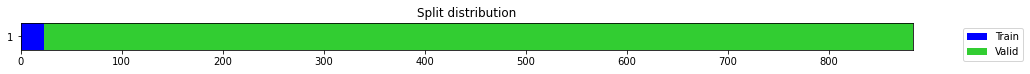

X      - shape: (884, 136)  type: ndarray  dtype:float32  isnan: 0
y      - shape: (884,)  type: ndarray  dtype:<U1  n_classes: 2 (442 samples per class) ['1', '2']  isnan: False
splits - n_splits: 2 shape: [23, 861]  overlap: False


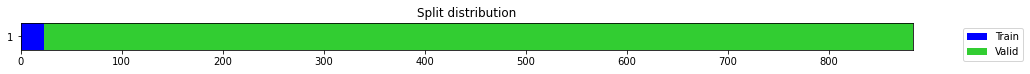

X      - shape: [884 samples x 1 features x 136 timesteps]  type: ndarray  dtype:float32  isnan: 0
y      - shape: (884,)  type: ndarray  dtype:float32  isnan: 0
splits - n_splits: 2 shape: [23, 861]  overlap: False


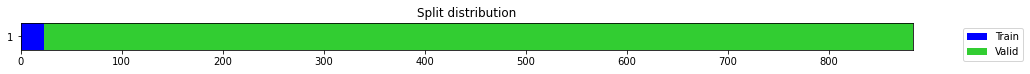

X      - shape: (884, 136)  type: ndarray  dtype:float32  isnan: 0
y      - shape: (884,)  type: ndarray  dtype:float32  isnan: 10
splits - n_splits: 2 shape: [23, 861]  overlap: False


/Users/nacho/opt/anaconda3/envs/py37torch110/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: y contains nan values


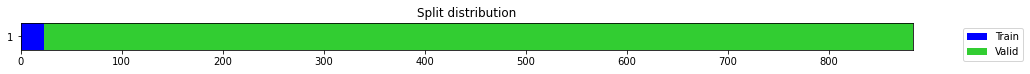

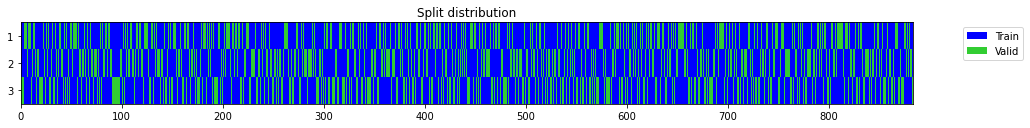

X      - shape: [884 samples x 1 features x 136 timesteps]  type: ndarray  dtype:float32  isnan: 0
y      - shape: (884,)  type: ndarray  dtype:<U1  n_classes: 2 (442 samples per class) ['1', '2']  isnan: False
splits - n_splits: 3 shape: [[589, 295], [589, 295], [590, 294]]  overlap: [False, False, False]


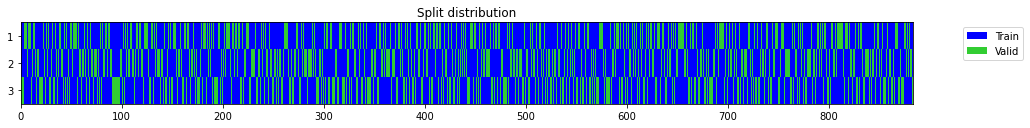

X      - shape: (884, 136)  type: ndarray  dtype:float32  isnan: 0
y      - shape: (884,)  type: ndarray  dtype:<U1  n_classes: 2 (442 samples per class) ['1', '2']  isnan: False
splits - n_splits: 3 shape: [[589, 295], [589, 295], [590, 294]]  overlap: [False, False, False]


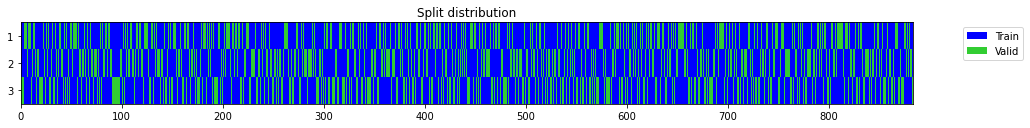

X      - shape: (884, 136)  type: ndarray  dtype:float32  isnan: 0
y      - shape: (884,)  type: ndarray  dtype:<U1  n_classes: 3 (294 samples per class) ['1', '2', 'n']  isnan: False
splits - n_splits: 3 shape: [[589, 295], [589, 295], [590, 294]]  overlap: [False, False, False]


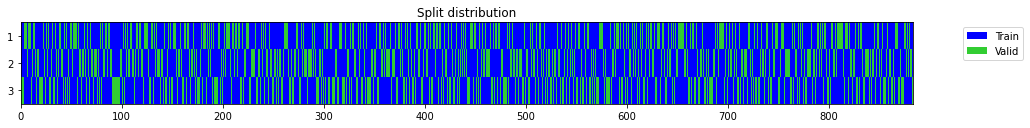

In [ ]:
dsid = 'ECGFiveDays'
X, y, splits = get_UCR_data(dsid, split_data=False, on_disk=False, force_download=False)
check_data(X, y, splits)
check_data(X[:, 0], y, splits)
y = y.astype(np.float32)
check_data(X, y, splits)
y[:10] = np.nan
check_data(X[:, 0], y, splits)
X, y, splits = get_UCR_data(dsid, split_data=False, on_disk=False, force_download=False)
splits = get_splits(y, 3)
check_data(X, y, splits)
check_data(X[:, 0], y, splits)
y[:5]= np.nan
check_data(X[:, 0], y, splits)
X, y, splits = get_UCR_data(dsid, split_data=False, on_disk=False, force_download=False)

In [ ]:
#export
def get_Monash_regression_list():
    return sorted([
        "AustraliaRainfall", "HouseholdPowerConsumption1",
        "HouseholdPowerConsumption2", "BeijingPM25Quality",
        "BeijingPM10Quality", "Covid3Month", "LiveFuelMoistureContent",
        "FloodModeling1", "FloodModeling2", "FloodModeling3",
        "AppliancesEnergy", "BenzeneConcentration", "NewsHeadlineSentiment",
        "NewsTitleSentiment", "IEEEPPG",  
        #"BIDMC32RR", "BIDMC32HR", "BIDMC32SpO2", "PPGDalia" # Cannot be downloaded
    ])

Monash_regression_list = get_Monash_regression_list()
regression_list = Monash_regression_list
TSR_datasets = regression_datasets = regression_list
len(Monash_regression_list)

15

In [ ]:
#export
def get_Monash_regression_data(dsid, path='./data/Monash', on_disk=True, mode='c', Xdtype='float32', ydtype=None, split_data=True, force_download=False, 
                               verbose=False, timeout=4):

    dsid_list = [rd for rd in Monash_regression_list if rd.lower() == dsid.lower()]
    assert len(dsid_list) > 0, f'{dsid} is not a Monash dataset'
    dsid = dsid_list[0]
    full_tgt_dir = Path(path)/dsid
    pv(f'Dataset: {dsid}', verbose)

    if force_download or not all([os.path.isfile(f'{path}/{dsid}/{fn}.npy') for fn in ['X_train', 'X_valid', 'y_train', 'y_valid', 'X', 'y']]):
        if dsid == 'AppliancesEnergy': dset_id = 3902637
        elif dsid == 'HouseholdPowerConsumption1': dset_id = 3902704
        elif dsid == 'HouseholdPowerConsumption2': dset_id = 3902706
        elif dsid == 'BenzeneConcentration': dset_id = 3902673
        elif dsid == 'BeijingPM25Quality': dset_id = 3902671
        elif dsid == 'BeijingPM10Quality': dset_id = 3902667
        elif dsid == 'LiveFuelMoistureContent': dset_id = 3902716
        elif dsid == 'FloodModeling1': dset_id = 3902694
        elif dsid == 'FloodModeling2': dset_id = 3902696
        elif dsid == 'FloodModeling3': dset_id = 3902698
        elif dsid == 'AustraliaRainfall': dset_id = 3902654
        elif dsid == 'PPGDalia': dset_id = 3902728
        elif dsid == 'IEEEPPG': dset_id = 3902710
        elif dsid == 'BIDMCRR' or dsid == 'BIDM32CRR': dset_id = 3902685
        elif dsid == 'BIDMCHR' or dsid == 'BIDM32CHR': dset_id = 3902676
        elif dsid == 'BIDMCSpO2' or dsid == 'BIDM32CSpO2': dset_id = 3902688
        elif dsid == 'NewsHeadlineSentiment': dset_id = 3902718
        elif dsid == 'NewsTitleSentiment': dset_id= 3902726
        elif dsid == 'Covid3Month': dset_id = 3902690

        for split in ['TRAIN', 'TEST']:
            url = f"https://zenodo.org/record/{dset_id}/files/{dsid}_{split}.ts"
            fname = Path(path)/f'{dsid}/{dsid}_{split}.ts'
            pv('downloading data...', verbose)
            try:
                download_data(url, fname, c_key='archive', force_download=force_download, timeout=timeout)
            except Exception as inst:
                print(inst)
                warnings.warn(f'Cannot download {dsid} dataset')
                if split_data: return None, None, None, None
                else: return None, None, None
            pv('...download complete', verbose)
            try: 
                if split == 'TRAIN':
                    X_train, y_train = _ts2dfV2(fname)
                    X_train = _check_X(X_train, coerce_to_numpy=True)
                else:
                    X_valid, y_valid = _ts2dfV2(fname)
                    X_valid = _check_X(X_valid, coerce_to_numpy=True)
            except Exception as inst:
                print(inst)
                warnings.warn(f'Cannot create numpy arrays for {dsid} dataset')
                if split_data: return None, None, None, None
                else: return None, None, None
        np.save(f'{full_tgt_dir}/X_train.npy', X_train)
        np.save(f'{full_tgt_dir}/y_train.npy', y_train)
        np.save(f'{full_tgt_dir}/X_valid.npy', X_valid)
        np.save(f'{full_tgt_dir}/y_valid.npy', y_valid)
        np.save(f'{full_tgt_dir}/X.npy', concat(X_train, X_valid))
        np.save(f'{full_tgt_dir}/y.npy', concat(y_train, y_valid))
        del X_train, X_valid, y_train, y_valid
        delete_all_in_dir(full_tgt_dir, exception='.npy')
        pv('...numpy arrays correctly saved', verbose)

    mmap_mode = mode if on_disk else None
    X_train = np.load(f'{full_tgt_dir}/X_train.npy', mmap_mode=mmap_mode)
    y_train = np.load(f'{full_tgt_dir}/y_train.npy', mmap_mode=mmap_mode)
    X_valid = np.load(f'{full_tgt_dir}/X_valid.npy', mmap_mode=mmap_mode)
    y_valid = np.load(f'{full_tgt_dir}/y_valid.npy', mmap_mode=mmap_mode)
    if Xdtype is not None: 
        X_train = X_train.astype(Xdtype)
        X_valid = X_valid.astype(Xdtype)
    if ydtype is not None: 
        y_train = y_train.astype(ydtype)
        y_valid = y_valid.astype(ydtype)

    if split_data:
        if verbose:
            print('X_train:', X_train.shape)
            print('y_train:', y_train.shape)
            print('X_valid:', X_valid.shape)
            print('y_valid:', y_valid.shape, '\n')
        return X_train, y_train, X_valid, y_valid
    else:
        X = np.load(f'{full_tgt_dir}/X.npy', mmap_mode=mmap_mode)
        y = np.load(f'{full_tgt_dir}/y.npy', mmap_mode=mmap_mode)
        splits = get_predefined_splits(X_train, X_valid)
        if verbose:
            print('X      :', X .shape)
            print('y      :', y .shape)
            print('splits :', coll_repr(splits[0]), coll_repr(splits[1]), '\n')
        return X, y, splits


get_regression_data = get_Monash_regression_data

In [ ]:
dsid = "Covid3Month"
X_train, y_train, X_valid, y_valid = get_Monash_regression_data(dsid, on_disk=False, split_data=True, force_download=False)
X, y, splits = get_Monash_regression_data(dsid, on_disk=True, split_data=False, force_download=False, verbose=True)
if X_train is not None: 
    test_eq(X_train.shape, (140, 1, 84))
if X is not None: 
    test_eq(X.shape, (201, 1, 84))

Dataset: Covid3Month
X      : (201, 1, 84)
y      : (201,)
splits : (#140) [0,1,2,3,4,5,6,7,8,9...] (#61) [140,141,142,143,144,145,146,147,148,149...] 



In [ ]:
#export
def get_forecasting_list():
    return sorted([
        "Sunspots", "Weather"
    ])

forecasting_time_series = get_forecasting_list()

In [ ]:
#export
def get_forecasting_time_series(dsid, path='./data/forecasting/', force_download=False, verbose=True, **kwargs):
    
    dsid_list = [fd for fd in forecasting_time_series if fd.lower() == dsid.lower()]
    assert len(dsid_list) > 0, f'{dsid} is not a forecasting dataset'
    dsid = dsid_list[0]
    if dsid == 'Weather': full_tgt_dir = Path(path)/f'{dsid}.csv.zip'
    else: full_tgt_dir = Path(path)/f'{dsid}.csv'
    pv(f'Dataset: {dsid}', verbose)
    if dsid == 'Sunspots': url = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv"
    elif dsid == 'Weather': url = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip'

    try: 
        pv("downloading data...", verbose)
        if force_download: 
            try: os.remove(full_tgt_dir)
            except OSError: pass
        download_data(url, full_tgt_dir, force_download=force_download, **kwargs)
        pv(f"...data downloaded. Path = {full_tgt_dir}", verbose)

        if dsid == 'Sunspots': 
            df = pd.read_csv(full_tgt_dir, parse_dates=['Date'], index_col=['Date'])
            return df['Monthly Mean Total Sunspot Number'].asfreq('1M').to_frame()

        elif dsid == 'Weather':
            # This code comes from a great Keras time-series tutorial notebook (https://www.tensorflow.org/tutorials/structured_data/time_series)
            df = pd.read_csv(full_tgt_dir)
            df = df[5::6] # slice [start:stop:step], starting from index 5 take every 6th record.

            date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

            # remove error (negative wind)
            wv = df['wv (m/s)']
            bad_wv = wv == -9999.0
            wv[bad_wv] = 0.0

            max_wv = df['max. wv (m/s)']
            bad_max_wv = max_wv == -9999.0
            max_wv[bad_max_wv] = 0.0

            wv = df.pop('wv (m/s)')
            max_wv = df.pop('max. wv (m/s)')

            # Convert to radians.
            wd_rad = df.pop('wd (deg)')*np.pi / 180

            # Calculate the wind x and y components.
            df['Wx'] = wv*np.cos(wd_rad)
            df['Wy'] = wv*np.sin(wd_rad)

            # Calculate the max wind x and y components.
            df['max Wx'] = max_wv*np.cos(wd_rad)
            df['max Wy'] = max_wv*np.sin(wd_rad)

            timestamp_s = date_time.map(datetime.timestamp)
            day = 24*60*60
            year = (365.2425)*day

            df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
            df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
            df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
            df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
            df.reset_index(drop=True, inplace=True)
            return df
        else: 
            return full_tgt_dir
    except Exception as inst:
        print(inst)
        warnings.warn(f"Cannot download {dsid} dataset")
        return

In [ ]:
ts = get_forecasting_time_series("sunspots", force_download=False)
test_eq(len(ts), 3235)
ts

Dataset: Sunspots
downloading data...
...data downloaded. Path = data/forecasting/Sunspots.csv


,Monthly Mean Total Sunspot Number
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7
...,...
2018-03-31,2.5
2018-04-30,8.9
2018-05-31,13.2


In [ ]:
ts = get_forecasting_time_series("weather", force_download=False)
if ts is not None: 
    test_eq(len(ts), 70091)
    print(ts)

Dataset: Weather
downloading data...
...data downloaded. Path = data/forecasting/Weather.csv.zip
module 'datetime' has no attribute 'timestamp'


/Users/nacho/opt/anaconda3/envs/py37torch110/lib/python3.7/site-packages/ipykernel_launcher.py:69: UserWarning: Cannot download Weather dataset


In [ ]:
# export
Monash_forecasting_list = ['m1_yearly_dataset',
                           'm1_quarterly_dataset',
                           'm1_monthly_dataset',
                           'm3_yearly_dataset',
                           'm3_quarterly_dataset',
                           'm3_monthly_dataset',
                           'm3_other_dataset',
                           'm4_yearly_dataset',
                           'm4_quarterly_dataset',
                           'm4_monthly_dataset',
                           'm4_weekly_dataset',
                           'm4_daily_dataset',
                           'm4_hourly_dataset',
                           'tourism_yearly_dataset',
                           'tourism_quarterly_dataset',
                           'tourism_monthly_dataset',
                           'nn5_daily_dataset_with_missing_values',
                           'nn5_daily_dataset_without_missing_values',
                           'nn5_weekly_dataset',
                           'cif_2016_dataset',
                           'kaggle_web_traffic_dataset_with_missing_values',
                           'kaggle_web_traffic_dataset_without_missing_values',
                           'kaggle_web_traffic_weekly_dataset',
                           'solar_10_minutes_dataset',
                           'solar_weekly_dataset',
                           'electricity_hourly_dataset',
                           'electricity_weekly_dataset',
                           'london_smart_meters_dataset_with_missing_values',
                           'london_smart_meters_dataset_without_missing_values',
                           'wind_farms_minutely_dataset_with_missing_values',
                           'wind_farms_minutely_dataset_without_missing_values',
                           'car_parts_dataset_with_missing_values',
                           'car_parts_dataset_without_missing_values',
                           'dominick_dataset',
                           'fred_md_dataset',
                           'traffic_hourly_dataset',
                           'traffic_weekly_dataset',
                           'pedestrian_counts_dataset',
                           'hospital_dataset',
                           'covid_deaths_dataset',
                           'kdd_cup_2018_dataset_with_missing_values',
                           'kdd_cup_2018_dataset_without_missing_values',
                           'weather_dataset',
                           'sunspot_dataset_with_missing_values',
                           'sunspot_dataset_without_missing_values',
                           'saugeenday_dataset',
                           'us_births_dataset',
                           'elecdemand_dataset',
                           'solar_4_seconds_dataset',
                           'wind_4_seconds_dataset',
                           'Sunspots', 'Weather']


forecasting_list = Monash_forecasting_list

In [ ]:
# export

## Original code available at: https://github.com/rakshitha123/TSForecasting
# This repository contains the implementations related to the experiments of a set of publicly available datasets that are used in 
# the time series forecasting research space.

# The benchmark datasets are available at: https://zenodo.org/communities/forecasting. For more details, please refer to our website: 
# https://forecastingdata.org/ and paper: https://arxiv.org/abs/2105.06643.

# Citation: 
# @misc{godahewa2021monash,
# author="Godahewa, Rakshitha and Bergmeir, Christoph and Webb, Geoffrey I. and Hyndman, Rob J. and Montero-Manso, Pablo",
# title="Monash Time Series Forecasting Archive",
# howpublished ="\url{https://arxiv.org/abs/2105.06643}",
# year="2021"
# }


# Converts the contents in a .tsf file into a dataframe and returns it along with other meta-data of the dataset: frequency, horizon, whether the dataset contains missing values and whether the series have equal lengths
#
# Parameters
# full_file_path_and_name - complete .tsf file path
# replace_missing_vals_with - a term to indicate the missing values in series in the returning dataframe
# value_column_name - Any name that is preferred to have as the name of the column containing series values in the returning dataframe
def convert_tsf_to_dataframe(full_file_path_and_name, replace_missing_vals_with = 'NaN', value_column_name = "series_value"):
    col_names = []
    col_types = []
    all_data = {}
    line_count = 0
    frequency = None
    forecast_horizon = None
    contain_missing_values = None
    contain_equal_length = None
    found_data_tag = False
    found_data_section = False
    started_reading_data_section = False

    with open(full_file_path_and_name, 'r', encoding='cp1252') as file:
        for line in file:
            # Strip white space from start/end of line
            line = line.strip()

            if line:
                if line.startswith("@"): # Read meta-data
                    if not line.startswith("@data"):
                        line_content = line.split(" ")
                        if line.startswith("@attribute"):
                            if (len(line_content) != 3):  # Attributes have both name and type
                                raise _TsFileParseException("Invalid meta-data specification.")

                            col_names.append(line_content[1])
                            col_types.append(line_content[2])
                        else:
                            if len(line_content) != 2:  # Other meta-data have only values
                                raise _TsFileParseException("Invalid meta-data specification.")

                            if line.startswith("@frequency"):
                                frequency = line_content[1]
                            elif line.startswith("@horizon"):
                                forecast_horizon = int(line_content[1])
                            elif line.startswith("@missing"):
                                contain_missing_values = bool(distutils.util.strtobool(line_content[1]))
                            elif line.startswith("@equallength"):
                                contain_equal_length = bool(distutils.util.strtobool(line_content[1]))

                    else:
                        if len(col_names) == 0:
                            raise _TsFileParseException("Missing attribute section. Attribute section must come before data.")

                        found_data_tag = True
                elif not line.startswith("#"):
                    if len(col_names) == 0:
                        raise _TsFileParseException("Missing attribute section. Attribute section must come before data.")
                    elif not found_data_tag:
                        raise _TsFileParseException("Missing @data tag.")
                    else:
                        if not started_reading_data_section:
                            started_reading_data_section = True
                            found_data_section = True
                            all_series = []

                            for col in col_names:
                                all_data[col] = []

                        full_info = line.split(":")

                        if len(full_info) != (len(col_names) + 1):
                            raise _TsFileParseException("Missing attributes/values in series.")

                        series = full_info[len(full_info) - 1]
                        series = series.split(",")

                        if(len(series) == 0):
                            raise _TsFileParseException("A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series. Missing values should be indicated with ? symbol")

                        numeric_series = []

                        for val in series:
                            if val == "?":
                                numeric_series.append(replace_missing_vals_with)
                            else:
                                numeric_series.append(float(val))

                        if (numeric_series.count(replace_missing_vals_with) == len(numeric_series)):
                            raise _TsFileParseException("All series values are missing. A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series.")

                        all_series.append(pd.Series(numeric_series).array)

                        for i in range(len(col_names)):
                            att_val = None
                            if col_types[i] == "numeric":
                                att_val = int(full_info[i])
                            elif col_types[i] == "string":
                                att_val = str(full_info[i])
                            elif col_types[i] == "date":
                                att_val = datetime.datetime.strptime(full_info[i], '%Y-%m-%d %H-%M-%S')
                            else:
                                raise _TsFileParseException("Invalid attribute type.") # Currently, the code supports only numeric, string and date types. Extend this as required.

                            if(att_val == None):
                                raise _TsFileParseException("Invalid attribute value.")
                            else:
                                all_data[col_names[i]].append(att_val)

                line_count = line_count + 1

        if line_count == 0:
            raise _TsFileParseException("Empty file.")
        if len(col_names) == 0:
            raise _TsFileParseException("Missing attribute section.")
        if not found_data_section:
            raise _TsFileParseException("Missing series information under data section.")

        all_data[value_column_name] = all_series
        loaded_data = pd.DataFrame(all_data)

        return loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length

In [ ]:
# export

def get_Monash_forecasting_data(dsid, path='./data/forecasting/', force_download=False, remove_from_disk=False, verbose=True):

    pv(f'Dataset: {dsid}', verbose)
    dsid = dsid.lower()
    assert dsid in Monash_forecasting_list, f'{dsid} not available in Monash_forecasting_list'

    if dsid == 'm1_yearly_dataset': url = 'https://zenodo.org/record/4656193/files/m1_yearly_dataset.zip'
    elif dsid == 'm1_quarterly_dataset': url = 'https://zenodo.org/record/4656154/files/m1_quarterly_dataset.zip'
    elif dsid == 'm1_monthly_dataset': url = 'https://zenodo.org/record/4656159/files/m1_monthly_dataset.zip'
    elif dsid == 'm3_yearly_dataset': url = 'https://zenodo.org/record/4656222/files/m3_yearly_dataset.zip'
    elif dsid == 'm3_quarterly_dataset': url = 'https://zenodo.org/record/4656262/files/m3_quarterly_dataset.zip'
    elif dsid == 'm3_monthly_dataset': url = 'https://zenodo.org/record/4656298/files/m3_monthly_dataset.zip'
    elif dsid == 'm3_other_dataset': url = 'https://zenodo.org/record/4656335/files/m3_other_dataset.zip'
    elif dsid == 'm4_yearly_dataset': url = 'https://zenodo.org/record/4656379/files/m4_yearly_dataset.zip'
    elif dsid == 'm4_quarterly_dataset': url = 'https://zenodo.org/record/4656410/files/m4_quarterly_dataset.zip'
    elif dsid == 'm4_monthly_dataset': url = 'https://zenodo.org/record/4656480/files/m4_monthly_dataset.zip'
    elif dsid == 'm4_weekly_dataset': url = 'https://zenodo.org/record/4656522/files/m4_weekly_dataset.zip'
    elif dsid == 'm4_daily_dataset': url = 'https://zenodo.org/record/4656548/files/m4_daily_dataset.zip'
    elif dsid == 'm4_hourly_dataset': url = 'https://zenodo.org/record/4656589/files/m4_hourly_dataset.zip'
    elif dsid == 'tourism_yearly_dataset': url = 'https://zenodo.org/record/4656103/files/tourism_yearly_dataset.zip'
    elif dsid == 'tourism_quarterly_dataset': url = 'https://zenodo.org/record/4656093/files/tourism_quarterly_dataset.zip'
    elif dsid == 'tourism_monthly_dataset': url = 'https://zenodo.org/record/4656096/files/tourism_monthly_dataset.zip'
    elif dsid == 'nn5_daily_dataset_with_missing_values': url = 'https://zenodo.org/record/4656110/files/nn5_daily_dataset_with_missing_values.zip'
    elif dsid == 'nn5_daily_dataset_without_missing_values': url = 'https://zenodo.org/record/4656117/files/nn5_daily_dataset_without_missing_values.zip'
    elif dsid == 'nn5_weekly_dataset': url = 'https://zenodo.org/record/4656125/files/nn5_weekly_dataset.zip'
    elif dsid == 'cif_2016_dataset': url = 'https://zenodo.org/record/4656042/files/cif_2016_dataset.zip'
    elif dsid == 'kaggle_web_traffic_dataset_with_missing_values': url = 'https://zenodo.org/record/4656080/files/kaggle_web_traffic_dataset_with_missing_values.zip'
    elif dsid == 'kaggle_web_traffic_dataset_without_missing_values': url = 'https://zenodo.org/record/4656075/files/kaggle_web_traffic_dataset_without_missing_values.zip'
    elif dsid == 'kaggle_web_traffic_weekly': url = 'https://zenodo.org/record/4656664/files/kaggle_web_traffic_weekly_dataset.zip'
    elif dsid == 'solar_10_minutes_dataset': url = 'https://zenodo.org/record/4656144/files/solar_10_minutes_dataset.zip'
    elif dsid == 'solar_weekly_dataset': url = 'https://zenodo.org/record/4656151/files/solar_weekly_dataset.zip'
    elif dsid == 'electricity_hourly_dataset': url = 'https://zenodo.org/record/4656140/files/electricity_hourly_dataset.zip'
    elif dsid == 'electricity_weekly_dataset': url = 'https://zenodo.org/record/4656141/files/electricity_weekly_dataset.zip'
    elif dsid == 'london_smart_meters_dataset_with_missing_values': url = 'https://zenodo.org/record/4656072/files/london_smart_meters_dataset_with_missing_values.zip'
    elif dsid == 'london_smart_meters_dataset_without_missing_values': url = 'https://zenodo.org/record/4656091/files/london_smart_meters_dataset_without_missing_values.zip'
    elif dsid == 'wind_farms_minutely_dataset_with_missing_values': url = 'https://zenodo.org/record/4654909/files/wind_farms_minutely_dataset_with_missing_values.zip'
    elif dsid == 'wind_farms_minutely_dataset_without_missing_values': url = 'https://zenodo.org/record/4654858/files/wind_farms_minutely_dataset_without_missing_values.zip'
    elif dsid == 'car_parts_dataset_with_missing_values': url = 'https://zenodo.org/record/4656022/files/car_parts_dataset_with_missing_values.zip'
    elif dsid == 'car_parts_dataset_without_missing_values': url = 'https://zenodo.org/record/4656021/files/car_parts_dataset_without_missing_values.zip'
    elif dsid == 'dominick_dataset': url = 'https://zenodo.org/record/4654802/files/dominick_dataset.zip'
    elif dsid == 'fred_md_dataset': url = 'https://zenodo.org/record/4654833/files/fred_md_dataset.zip'
    elif dsid == 'traffic_hourly_dataset': url = 'https://zenodo.org/record/4656132/files/traffic_hourly_dataset.zip'
    elif dsid == 'traffic_weekly_dataset': url = 'https://zenodo.org/record/4656135/files/traffic_weekly_dataset.zip'
    elif dsid == 'pedestrian_counts_dataset': url = 'https://zenodo.org/record/4656626/files/pedestrian_counts_dataset.zip'
    elif dsid == 'hospital_dataset': url = 'https://zenodo.org/record/4656014/files/hospital_dataset.zip'
    elif dsid == 'covid_deaths_dataset': url = 'https://zenodo.org/record/4656009/files/covid_deaths_dataset.zip'
    elif dsid == 'kdd_cup_2018_dataset_with_missing_values': url = 'https://zenodo.org/record/4656719/files/kdd_cup_2018_dataset_with_missing_values.zip'
    elif dsid == 'kdd_cup_2018_dataset_without_missing_values': url = 'https://zenodo.org/record/4656756/files/kdd_cup_2018_dataset_without_missing_values.zip'
    elif dsid == 'weather_dataset': url = 'https://zenodo.org/record/4654822/files/weather_dataset.zip'
    elif dsid == 'sunspot_dataset_with_missing_values': url = 'https://zenodo.org/record/4654773/files/sunspot_dataset_with_missing_values.zip'
    elif dsid == 'sunspot_dataset_without_missing_values': url = 'https://zenodo.org/record/4654722/files/sunspot_dataset_without_missing_values.zip'
    elif dsid == 'saugeenday_dataset': url = 'https://zenodo.org/record/4656058/files/saugeenday_dataset.zip'
    elif dsid == 'us_births_dataset': url = 'https://zenodo.org/record/4656049/files/us_births_dataset.zip'
    elif dsid == 'elecdemand_dataset': url = 'https://zenodo.org/record/4656069/files/elecdemand_dataset.zip'
    elif dsid == 'solar_4_seconds_dataset': url = 'https://zenodo.org/record/4656027/files/solar_4_seconds_dataset.zip'
    elif dsid == 'wind_4_seconds_dataset': url = 'https://zenodo.org/record/4656032/files/wind_4_seconds_dataset.zip'

    path = Path(path)
    full_path = path/f'{dsid}.tsf'
    if not full_path.exists() or force_download: 
        try: 
            decompress_from_url(url, target_dir=path, verbose=verbose)
        except Exception as inst:
            print(inst)
    pv("converting dataframe to numpy array...", verbose)
    data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = convert_tsf_to_dataframe(full_path)
    X = to3d(stack_pad(data['series_value']))
    pv("...dataframe converted to numpy array", verbose)
    pv(f'\nX.shape: {X.shape}', verbose)  
    pv(f'freq: {frequency}', verbose)  
    pv(f'forecast_horizon: {forecast_horizon}', verbose)  
    pv(f'contain_missing_values: {contain_missing_values}', verbose)  
    pv(f'contain_equal_length: {contain_equal_length}', verbose=verbose)
    if remove_from_disk: os.remove(full_path)
    return X

get_forecasting_data = get_Monash_forecasting_data

In [ ]:
dsid = 'm1_yearly_dataset'
X = get_Monash_forecasting_data(dsid, force_download=False)
if X is not None: 
    test_eq(X.shape, (181, 1, 58))

Dataset: m1_yearly_dataset
converting dataframe to numpy array...
...dataframe converted to numpy array

X.shape: (181, 1, 58)
freq: yearly
forecast_horizon: 6
contain_missing_values: False
contain_equal_length: False


In [ ]:
#hide
from tsai.imports import create_scripts
from tsai.export import get_nb_name
nb_name = get_nb_name()
nb_name = "012_data.external.ipynb"
create_scripts(nb_name);

<IPython.core.display.Javascript object>

012_data.external.ipynb saved at 2022-03-02 13:24:37.
Converted 012_data.external.ipynb.


Correct conversion! 😃
Total time elapsed 0.177 s
Wednesday 02/03/22 13:24:41 CET
